Field Interpolation
==============

Given a set of samples of an unkown function $f$, estimate a function $g$.


In [66]:
import seaborn as sns
sns.set_theme()
sns.set(style='darkgrid', context='talk', palette='Pastel1')

In [67]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

$$f(0) = -1$$
$$f(1) = 0.2$$
$$f(2) = 0.9$$
$$f(3) = 2.1$$

Estimate a line, $g(x) = kx + m$, using linear last squares

$$-1 = k \cdot 0 + m$$
$$0.7 = k \cdot 1 + m$$
$$0.9 = k \cdot 2 + m$$
$$2.1 = k \cdot 3 + m$$

Or just

$$
\begin{bmatrix}
0 & 1 \\
1 & 1 \\
2 & 1 \\
3 & 1 \\
\end{bmatrix}
\begin{bmatrix} k \\ m \end{bmatrix}
= 
\begin{bmatrix}
-1 \\ 0.7 \\ 0.9 \\ 2.1 \\
\end{bmatrix}$$

$$A\begin{bmatrix} k \\ m \end{bmatrix} = \bf{b}$$

This is an _overdetermined_ system and in general all equations cannot be satisfied exactly, but we can minimize the squared error.

In [68]:
import numpy as np

# sampled points
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.7, 0.9, 2.1])

A = np.vstack([x, np.ones(x.shape)]).T
k, m = np.linalg.lstsq(A, y, rcond=None)[0]

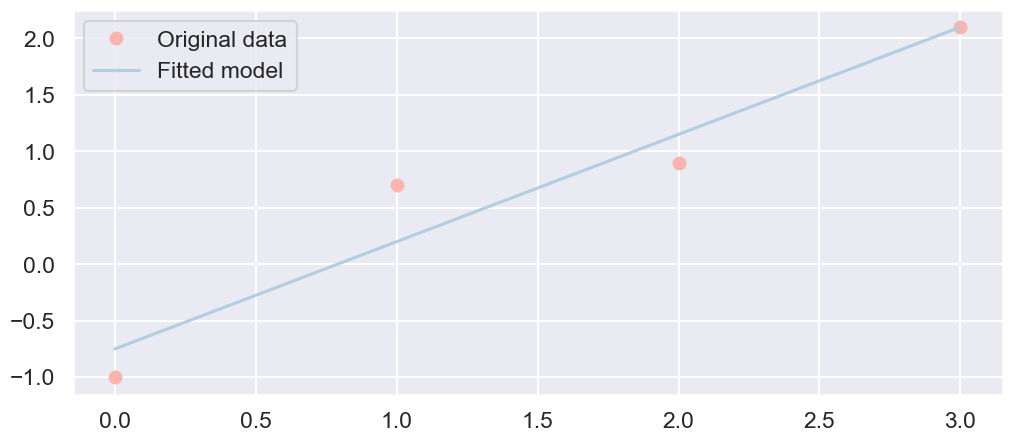

In [69]:
def plot(x0, y0, x1, y1):
    plt.plot(x0, y0, 'o', label='Original data')
    plt.plot(x1, y1, label='Fitted model')
    plt.legend()
    plt.show()

plot(x, y, x, k*x + m)

### Grid model
Instead of using a line, lets use the _values_ at specific lattice points as the model. We use a finite grid with a high and low limit.

Here the $g(n)$ grid values are the _unkown_ parameters we want to solve for.

$$
g(0) = f(0) = -1 \\
g(1) = f(1) = 0.7 \\
g(2) = f(2) = 0.9 \\
g(3) = f(3) = 2.1 \\
$$

$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
g(0) \\ g(1) \\ g(2) \\ g(3)
\end{bmatrix}
=
\begin{bmatrix}
-1 \\ 0.7 \\ 0.9 \\ 2.1 \\
\end{bmatrix}
$$

$$A\bf{x} = \bf{b}$$



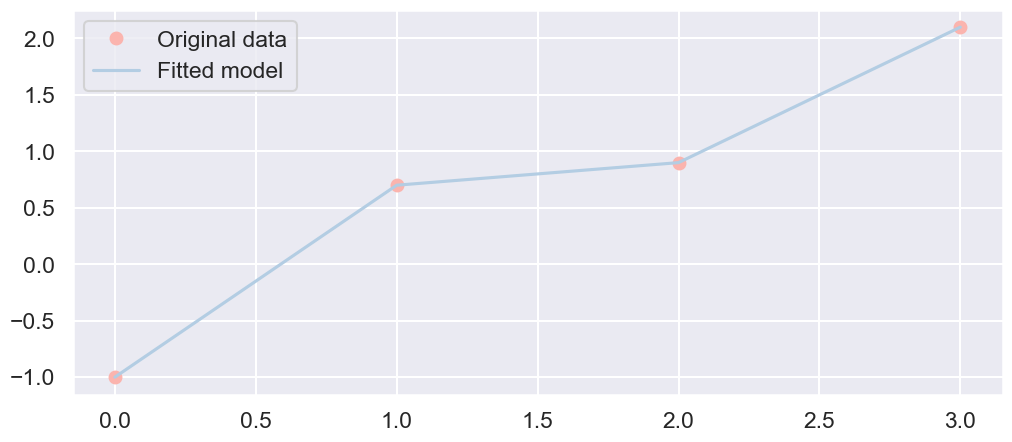

In [70]:
plot(x, y, x, y)

But what if we have more points? And that are not exactly _on_ the grid?

$$f(0) = -1$$
$$f(1) = 0.7$$
$$f(2) = 0.9$$
$$f(2.2) = 1.5$$
$$f(3) = 2.1$$

Then we do linear interpolation ("lerp"). The closest lattice points are 2 and 3.

$$(1 - 0.2) \cdot f(2) + 0.2 \cdot f(3) = 1.5$$

Now we have in matrix form

$$
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0.8 & 0.2 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
g(0) \\ g(1) \\ g(2) \\ g(3)
\end{bmatrix}
=
\begin{bmatrix}
-1 \\ 0.7 \\ 0.9 \\ 1.5 \\ 2.1 \\
\end{bmatrix}
$$

In [71]:
EPSILON = 1e-8

def value_constraints_1d(xx, n):
    rows = []
    for f, i in zip(*np.modf(xx)):
        row = np.zeros(n)
        if 1 - f > EPSILON:
            row[int(i)] = 1 - f
        if f > EPSILON:
            row[int(i) + 1] = f
        rows.append(row)
    return np.vstack(rows)
    
x = np.array([0, 1, 2, 2.2, 3])
y = np.array([-1, 0.7, 0.9, 1.5, 2.1])

A = value_constraints_1d(x, 4)
A

array([[1. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0.8, 0.2],
       [0. , 0. , 0. , 1. ]])

solving 5 equations for 4 unkowns


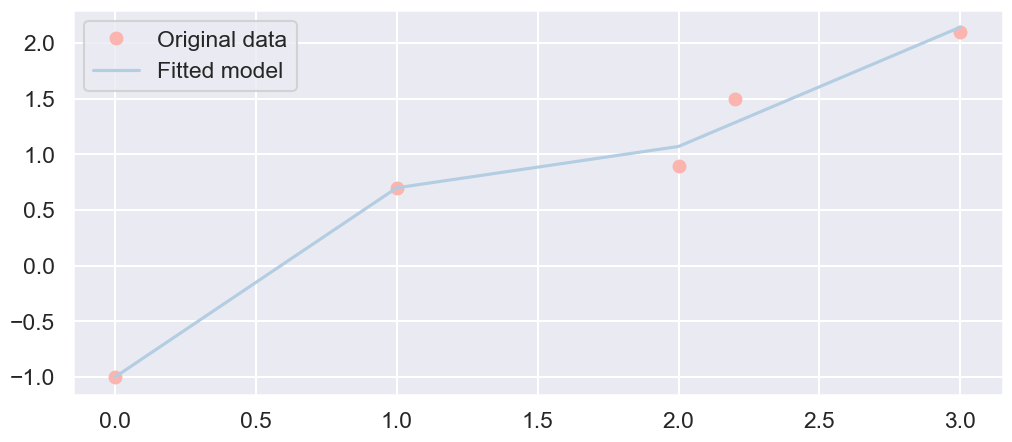

In [32]:
print(f"solving {A.shape[0]} equations for {A.shape[1]} unkowns")
g = np.linalg.lstsq(A, y, rcond=None)[0]
plot(x, y, np.arange(len(g)), g)

## Gradient constraints
We can also add gradient constraints if these are known. Intead of linear interpolation, just nearest neighgbor can be used. Let's say we know $f'(1.3) = 2.1$, we can add it as just $g(2) - g(1) = 2.1$


Or in matrix form

$$
\begin{bmatrix}
0 & -1 & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
g(0) \\ g(1) \\ g(2) \\ g(3)
\end{bmatrix}
=
\begin{bmatrix}
2.1 \\
\end{bmatrix}
$$

In [75]:
def gradient_constraints_1d(xx, n):
    rows = []
    for f, i in zip(*np.modf(xx)):
        del f  # ignore fraction part
        row = np.zeros(n)
        row[int(i)] = -1
        row[int(i + 1)] = 1
        rows.append(row)
    return np.vstack(rows)
    np.array([0])

gradients = np.array([0])
gradient_constraints_1d(np.array([0.5]), 4), gradients

(array([[-1.,  1.,  0.,  0.]]), array([0]))

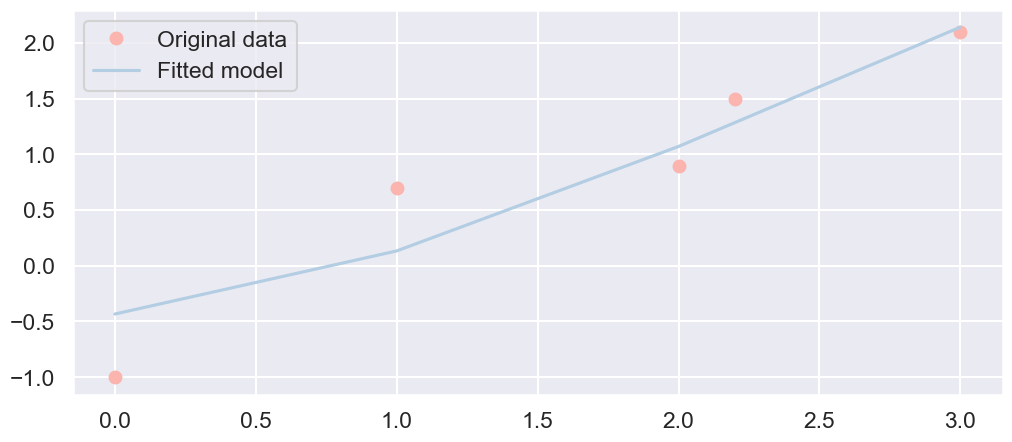

In [76]:
A = np.vstack([value_constraints_1d(x, 4), gradient_constraints_1d(np.array([0.5]), 4)])
xg = np.linalg.lstsq(A, np.hstack([y, gradients]), rcond=None)[0]
plot(x, y, np.arange(len(xg)), xg)

## Smoothess constraints
We can also coerce the grid model to be more smooth by $f''(x) = 0$. If we aproximate $f''$ by the finite difference $f'(x) = f(⌊x⌋ + 1) - f(⌊x⌋)$ (and likewise for $f''$) we can formulate it for grid cordinate $n$ like so

$$g''(n) = 0$$
$$g'(n + 1) - g'(n) = 0$$
$$(g(n + 2) - g(n + 1)) - (g(n + 1) - g(n)) = 0$$
$$g(n) - 2 g(n + 1) + g(n + 2) = 0$$


For our 4-element grid we get
$$g(0) - 2g(1) + g(2) = 0$$
$$g(1) - 2g(2) + g(3) = 0$$

Or in matrix form

$$
\begin{bmatrix}
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
\end{bmatrix}
\begin{bmatrix}
g(0) \\ g(1) \\ g(2) \\ g(3)
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 0 \\
\end{bmatrix}
$$

In [25]:
def smoothness_constraints_1d(n):
    rows = []
    for i in range(n - 2):
        row = np.zeros(n)
        row[i + 0] = 1
        row[i + 1] = -2
        row[i + 2] = 1
        rows.append(row)
    return np.vstack(rows)

smoothness_constraints_1d(4)

array([[ 1., -2.,  1.,  0.],
       [ 0.,  1., -2.,  1.]])

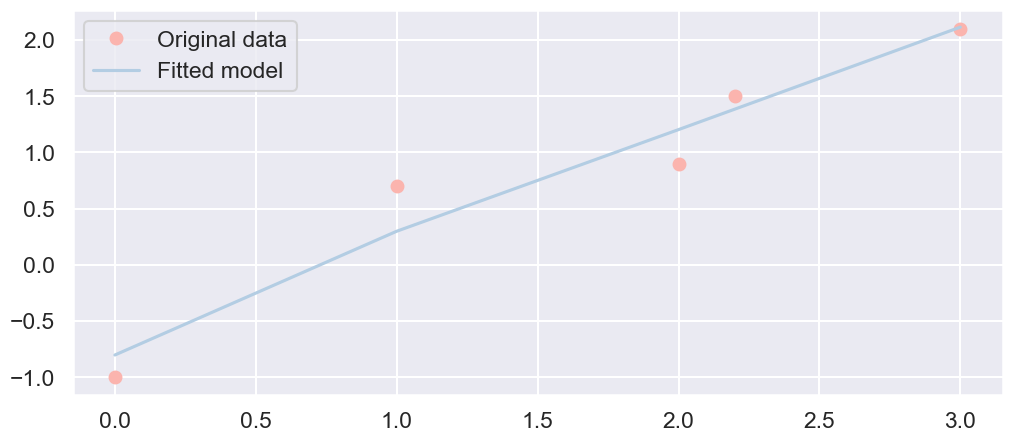

In [26]:
A = np.vstack([value_constraints_1d(x, 4), smoothness_constraints_1d(4)])
xg = np.linalg.lstsq(A, np.hstack([y, np.zeros(4 - 2)]), rcond=None)[0]
plot(x, y, np.arange(len(xg)), xg)

## Weights
We can easily weight the different constraints by just multiplying each row by a weight. We can easily also consider the spatial location of any normal, point or smoothness contraint, e.g. $w(\mathbf{p})$ so that any row $i$ of $A$ and corresponding row in $\mathbf{b}$ is multiplied by $w$. For example our gradient constraint from above ($f'(1.3) = 2.1$) can be weighted by its location 1.3.

$$
w(1.3)
\begin{bmatrix}
0 & -1 & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
g(0) \\ g(1) \\ g(2) \\ g(3)
\end{bmatrix}
=
w(1.3)
\begin{bmatrix}
2.1 \\
\end{bmatrix}
$$

And $w$ can either just be a constant to mean "trust all gradients this much relative to value and smoothness constraints" and so on. Or a function so that we might trust gradients near e.g. $x=0$ more and so on.

In [33]:
# interactive demo
from ipywidgets import interact
import ipywidgets as widgets

# example function
def gaussian(x, mu=0, sigma=1):
    return np.exp(-np.power(x - mu, 2) / (2 * np.power(sigma, 2)))

@interact(
    grid_size=widgets.IntSlider(11, min=3.0, max=64.0),
    n=widgets.IntSlider(16, min=2, max=128),
    sigma=widgets.FloatSlider(0.1, min=0.0, max=0.5),
    ws=widgets.FloatSlider(1.0, min=0.1, max=2.0, description="smoothness"),
    wv=widgets.FloatSlider(1.0, min=0.1, max=2.0, description="value"))
def demo_1d(grid_size, n, sigma, ws, wv):
    np.random.seed(17)
    x = np.random.random(n) * (grid_size - 1)
    y = gaussian(x, mu=(grid_size - 1) / 2, sigma=(grid_size-1) / 8) + np.random.normal(scale=sigma, size=x.shape)
    A = np.vstack([
        wv * value_constraints_1d(x, grid_size),
        ws * smoothness_constraints_1d(grid_size),
    ])
    
    print(f"solving {A.shape[0]} equations for {A.shape[1]} unkowns")
    g = np.linalg.lstsq(A, np.hstack([wv * y, np.zeros(grid_size - 2)]), rcond=None)[0]
    plot(x, y, np.arange(len(g)), g)


interactive(children=(IntSlider(value=11, description='grid_size', max=64, min=3), IntSlider(value=16, descrip…

## From another dimension
This is easy to extend with more dimenensions. 

### Grid coordinates
The unknown values of the grid are stacked ontop of each other. For example in a 3x3 arranged like so

$$
\begin{bmatrix}
g(0, 0) & g(0, 1) & g(0, 2) \\
g(1, 0) & g(1, 1) & g(1, 2) \\
g(2, 0) & g(2, 1) & g(2, 2) \\
\end{bmatrix}
$$

We would then have, for example, the following equation(s). But really any arrangement of the elements of the grid works.

$$
A
\begin{bmatrix}
g(0, 0) \\ g(0, 1) \\ g(0, 2) \\
g(1, 0) \\ g(1, 1) \\ g(1, 2) \\
g(2, 0) \\ g(2, 1) \\ g(2, 2) \\
\end{bmatrix}
= b
$$


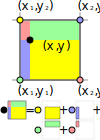

By Cmglee - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=21409164


In [79]:
from IPython.display import SVG, display
display(SVG('https://upload.wikimedia.org/wikipedia/commons/9/91/Bilinear_interpolation_visualisation.svg'))
print('By Cmglee - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=21409164')

### Value constraints
Let's say we know the value of the function at a specific point.
$f(1.2, 1.3) = 1.4$

Bilinear interpolation of the value yields

$$
(1 - 0.2) \cdot (1 - 0.3) \cdot g(1, 1) + \\
0.2 \cdot (1 - 0.3) \cdot g(1, 2) + \\
(1 - 0.2) \cdot 0.3 \cdot g(2, 1) + \\
0.2 \cdot 0.3 \cdot g(2, 2) = 1.4
$$

Or in matrix form

$$
\begin{bmatrix}
0 \\ 0 \\ 0 &
0 & (1 - 0.2) \cdot (1 - 0.3) & 0.2 \cdot (1 - 0.3) &
0 & (1 - 0.2) \cdot 0.3 & 0.2 \cdot 0.3
\end{bmatrix}
\begin{bmatrix}
g(0, 0) \\ g(0, 1) \\ g(0, 2) \\
g(1, 0) \\ g(1, 1) \\ g(1, 2) \\
g(2, 0) \\ g(2, 1) \\ g(2, 2) \\
\end{bmatrix}
=
\begin{bmatrix}
1.4
\end{bmatrix}
$$


### Gradient constraints
For example in 2D a gradient constraint $\nabla f(2.1, 5.8) = \begin{bmatrix} -1 & 3 \end{bmatrix}^T$ just becomes

$$g(3, 6) - g(2, 6) = -1$$
$$g(2, 6) - g(2, 5) =  3$$

### Smoothness constraints
Just as in 1D, we approximate the second order derivative with the finite difference to be able to express the constraint in the unkowns $g(n)$.

$$g''(x, y) = 0$$
$$g(x, y) - 2g(x + 1, y) + g(x+2, y) = 0$$
$$g(x, y) - 2g(x, y + 1) + g(x, y+2) = 0$$


## SVG example

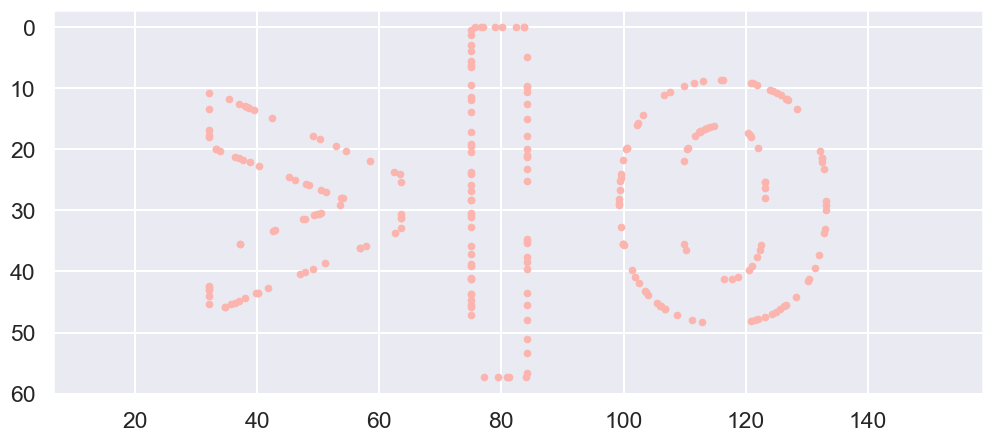

In [34]:
from typing import List

def from_complex(ca: List[complex]) -> np.ndarray:
    """convert to 2d cordinates from complex"""
    return np.vstack([ca.real, ca.imag]).T

from mini_svg.load import load_svg
shape = load_svg('volumental.svg')

np.random.seed(17)  # the unoffical KTH arbitrary number
ts = np.random.random(256)
sampled_points = from_complex(np.array([shape.point(t) for t in ts]))

plt.plot(sampled_points[:, 0], sampled_points[:, 1], '.', label='volumental.svg')
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.axis('equal')
plt.show()

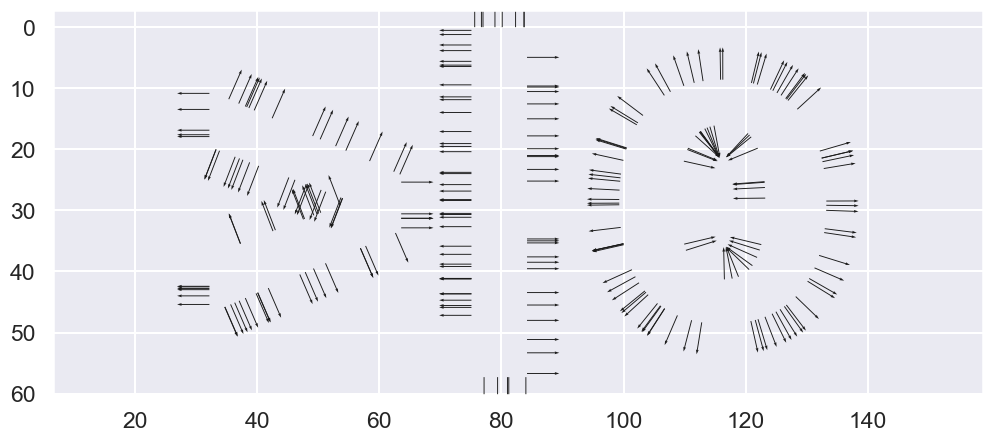

In [35]:
def normalize(a, axis=-1, order=2):
    """Normalizes array to have length 1 along specificed axis."""
    norms = np.linalg.norm(a, order, axis)
    return a / np.expand_dims(norms, axis)

sampled_normals = normalize(from_complex(np.array([shape.tangent(t) for t in ts]) * -1j))

plt.quiver(
    sampled_points[:, 0], sampled_points[:, 1],
    sampled_normals[:, 0], -sampled_normals[:, 1],
    width=0.001
)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.axis('equal')
plt.show()

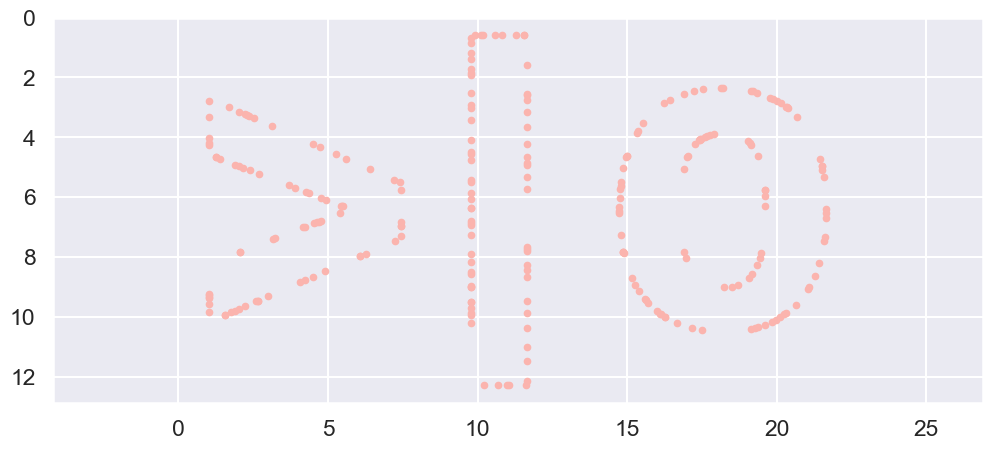

In [36]:
resolution = (14, 24)

def fit_to(a, resolution, padding_fraction=0):
    """Rescales cordinates to fit a specific resolution with paddning"""
    r = np.flip(np.array(resolution)) - np.array([1, 1])
    top_left = np.min(a, axis=0)
    bottom_right = np.max(a, axis=0)
    size = bottom_right - top_left
    scale = np.min(r / size)
    normalized = scale * (a - top_left)
    padding = r * padding_fraction
    return (normalized + 0.5 * padding) * (1 - padding_fraction)

points = fit_to(sampled_points, resolution, 0.1)
normals = sampled_normals  # normals are invariant to scaling and translation

plt.plot(points[:, 0], points[:, 1], '.', label='volumental.svg')
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.axis('equal')
plt.show()

solving 1296 equations for 336 unkowns


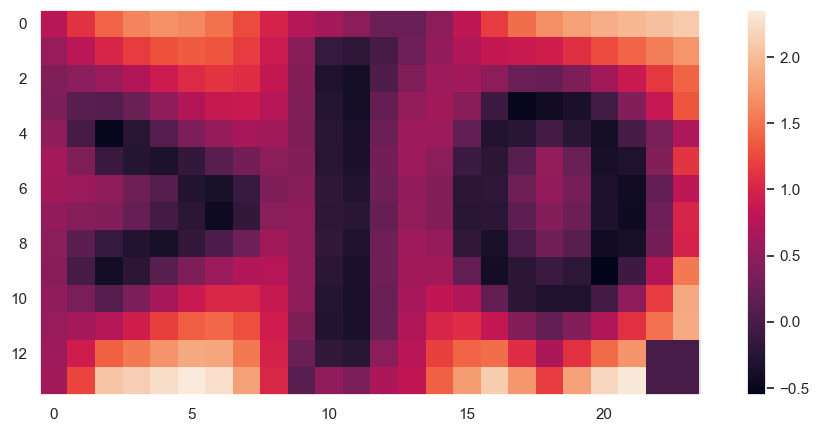

In [37]:
def index(x: int, y: int, resolution):
    """Returns the index into the grid vector"""
    _, w = resolution
    return int(x) + int(y) * w

def value_constraints_2d(points, values, resolution):
    """"binlinear interpolation"""
    rows = []
    n = np.prod(np.array(resolution))
    for (fx, fy), (ix, iy), value in zip(*np.modf(points), values):
        row = np.zeros(n)
        row[index(ix, iy, resolution)] = (1 - fx) * (1 - fy)
        row[index(ix + 1, iy, resolution)] = fx * (1 - fy)
        row[index(ix, iy + 1, resolution)] = (1 - fx) * fy
        row[index(ix + 1, iy + 1, resolution)] = fx * fy
        rows.append(row)
    
    return np.vstack(rows), values

def gradient_constraints_2d(points, normals, resolution):
    rows = []
    values = []
    n = np.prod(np.array(resolution))
    # ∇f(x, y) = (nx, ny)
    # nearest neighbor
    #f(⌊⌊x⌋ + 1, ⌊y⌋ + 1) - f(⌊x⌋, ⌊y⌋ + 1) = nx
    #f(⌊⌊x⌋, ⌊y⌋ + 1) - f(⌊x⌋, ⌊y⌋) = ny
    for (fx, fy), (ix, iy), (nx, ny) in zip(*np.modf(points), normals):
        del fx, fy  # ignore fraction part
        row = np.zeros(n)
        row[index(ix + 1, iy + 1, resolution)] = 1
        row[index(ix, iy + 1, resolution)] = -1
        rows.append(row)
        values.append(nx)
        
        row = np.zeros(n)
        row[index(ix, iy + 1, resolution)] = 1
        row[index(ix, iy, resolution)] = -1
        rows.append(row)
        values.append(ny)

    return np.array(rows), np.array(values)

def smoothness_constraints_2d(resolution):
    # f''(x) = 0 or
    # f(x, y) - 2·f(x+1, y) + f(x+2, y) = 0
    # f(x, y) - 2·f(x, y+1) + f(x, y+2) = 0

    rows = []
    values = []
    n = np.prod(np.array(resolution))
    h, w = resolution
    for iy, ix in np.ndindex(h - 2, w - 2):
        row = np.zeros(n)
        row[index(ix + 0, iy, resolution)] = 1
        row[index(ix + 1, iy, resolution)] = -2
        row[index(ix + 2, iy, resolution)] = 1
        rows.append(row)
        values.append(0)
        
        row = np.zeros(n)
        row[index(ix, iy + 0, resolution)] = 1
        row[index(ix, iy + 1, resolution)] = -2
        row[index(ix, iy + 2, resolution)] = 1
        rows.append(row)
        values.append(0)
        
    return np.array(rows), np.array(values)

def field_interpolation(resolution, points, normals):
    rows0, values0 = value_constraints_2d(points, np.zeros(len(points)), resolution)
    rows1, values1 = gradient_constraints_2d(points, normals, resolution)
    rows2, values2 = smoothness_constraints_2d(resolution)
    A = np.vstack([rows0, rows1, rows2])
    b = np.concatenate([values0, values1, values2])
    print(f"solving {A.shape[0]} equations for {A.shape[1]} unkowns")
    sdf = np.linalg.lstsq(A, b, rcond=None)[0]
    return sdf.reshape(resolution)

# get rid of gridliens
sns.set(style='dark')

# compute signed distance function (sdf)
sdf = field_interpolation(resolution, points, normals)

# show sdf
plt.imshow(sdf)
plt.colorbar()
plt.show()


(0.0, 23.0, 0.0, 13.0)

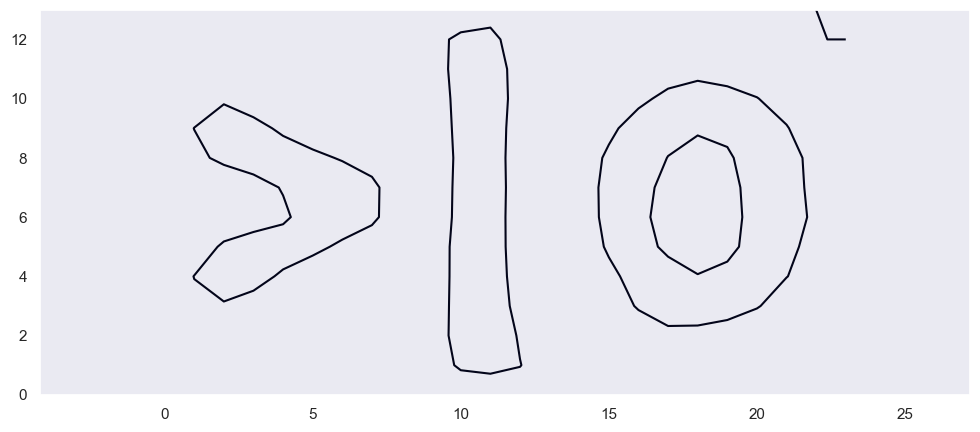

In [38]:
# plot reconstructed surface
plt.contour(sdf, levels=[0])
plt.axis('equal')

## Noise
Let's add ~make~ add some noise!


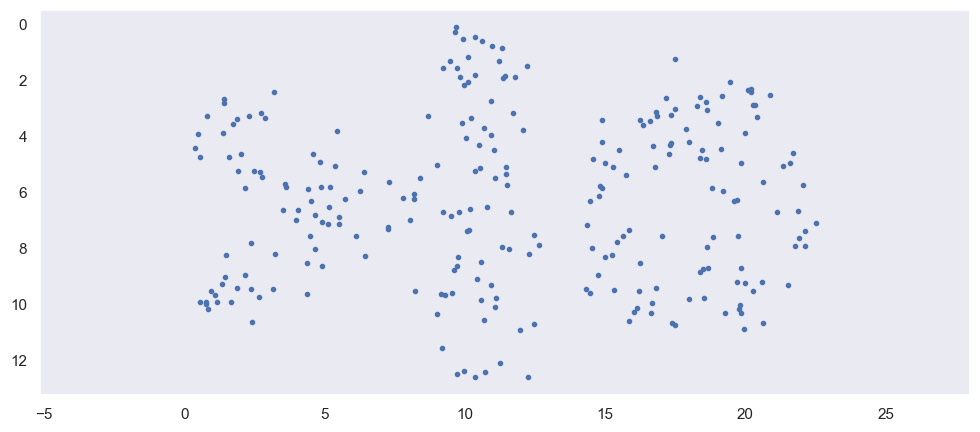

In [39]:
noisy_points = points + np.random.normal(scale=0.5, size=points.shape)

plt.plot(noisy_points[:, 0], noisy_points[:, 1], '.', label='noisy points')
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.axis('equal')
plt.show()

solving 1296 equations for 336 unkowns


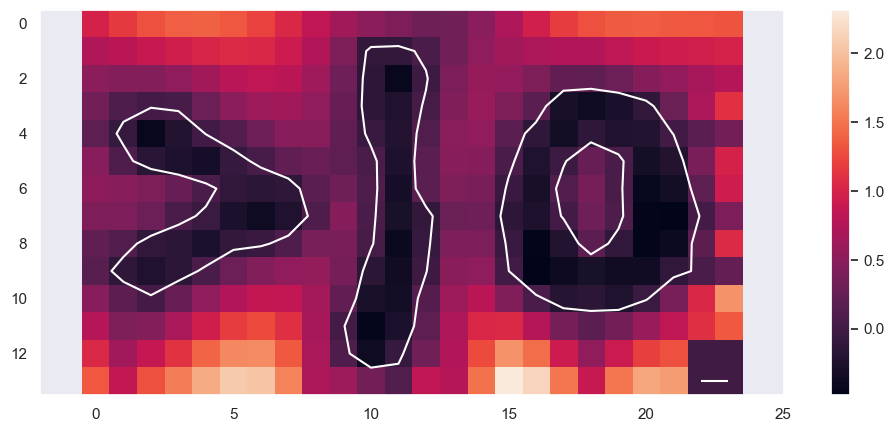

In [40]:
sdf = field_interpolation(resolution, noisy_points, normals)

plt.imshow(sdf)
plt.colorbar()

# plot reconstructed surface
plt.contour(sdf, levels=[0], colors='white')
plt.axis('equal')
plt.show()

In [41]:
# interactive demo
from ipywidgets import interact
import ipywidgets as widgets

def compute_sdf(resolution, shape, n, sigma):
    ts = np.random.random(n)
    sampled_points = from_complex(np.array([shape.point(t) for t in ts]))
    sampled_normals = normalize(from_complex(np.array([shape.tangent(t) for t in ts]) * -1j))
    normals = sampled_normals
    
    points = fit_to(sampled_points, resolution, 0.1)
    noisy_points = points + np.random.normal(scale=sigma, size=points.shape)

    # drop points outside grid
    inside = np.all(np.vstack([
        noisy_points[:, 0] < resolution[1] - 1,
        noisy_points[:, 1] < resolution[0] - 1,
    ]), axis=0)
    
    return field_interpolation(resolution, noisy_points[inside], normals[inside])

@interact(
    grid_scale=widgets.FloatSlider(8.0, min=3.0, max=20.0),
    n=widgets.IntSlider(256, min=0, max=1024),
    sigma=widgets.FloatSlider(0.5, min=0.0, max=3.0))
def demo_2d(grid_scale, n, sigma):
    np.random.seed(17)
    resolution = (int(2*grid_scale), int(3*grid_scale))

    sdf = compute_sdf(resolution, shape, n, sigma)

    plt.imshow(sdf)
    plt.colorbar()

    # plot reconstructed surface
    plt.contour(sdf, levels=[0], colors='white')
    plt.axis('equal')
    plt.show()

interactive(children=(FloatSlider(value=8.0, description='grid_scale', max=20.0, min=3.0), IntSlider(value=256…

## Gradient fields

solving 3528 equations for 1536 unkowns


(-2.35, 49.35, -1.55, 32.55)

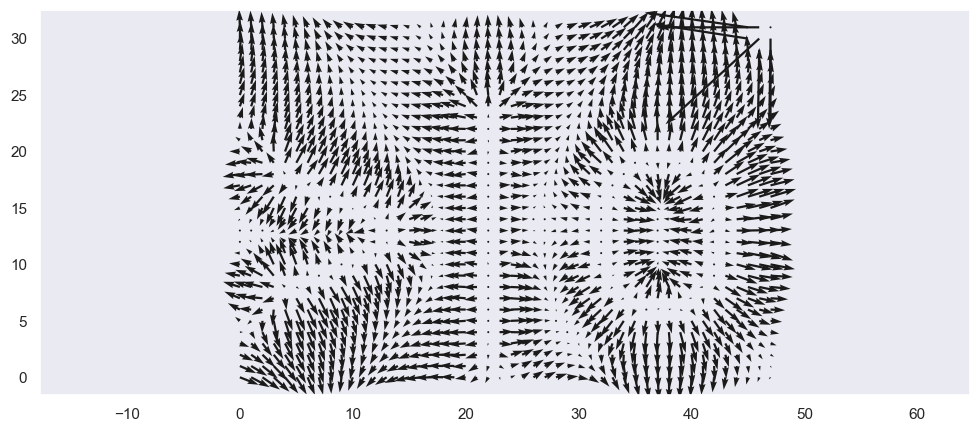

In [42]:
sdf = compute_sdf((32, 48), shape, 256, 0)

dy, dx = np.gradient(sdf)
plt.quiver(dx, dy)
plt.axis('equal')

## Questions?